# **_Essential Imports_**

In [9]:
import numpy as np
import pandas as pd
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import mlflow
import optuna
from ultralytics import YOLO
import xml.etree.ElementTree as ET
import cv2

c:\Users\hosam\anaconda3\envs\CV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **_Global Variables And Helper Functions_**

In [10]:
SRC_DIR = r'dataset'
DST_DIR = r'Yolo_Dataset'
CLASS_NAMES = []
os.makedirs(DST_DIR, exist_ok=True)

In [11]:
def is_image(filepath):
    try:
        img = Image.open(filepath)
        img.verify()
        return filepath.endswith(('.png', '.jpg', '.webp', '.jpeg'))
    except Exception as e:
        return False

In [12]:
def is_xml(filepath):
    return filepath.endswith('.xml')

In [13]:
def pick_random_image(folder_path):
    return np.random.randint(0,len(os.listdir(folder_path)))

In [14]:
def parse_xml_tree(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    filename = root.find('filename').text.replace('.jpg', '')

    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    objects = []

    for obj in root.findall('object'):
        label = obj.find('name').text
        # Assign unique class ID per label in this file
        if label not in CLASS_NAMES:
            CLASS_NAMES.append(label)
            class_id = len(CLASS_NAMES) - 1
        else:
            class_id = CLASS_NAMES.index(label)

        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        objects.append({
            'class_id': class_id,
            'label': label,
            'bbox': [xmin, ymin, xmax, ymax]
        })

    return [filename, width, height, objects]


In [15]:
# def parse_xml_tree(file_path):
#     tree = ET.parse(file_path)
#     root = tree.getroot()

#     filename = root.find('filename').text.replace('.jpg','')

#     size = root.find('size')
#     width = int(size.find('width').text)
#     height = int(size.find('height').text)

#     objects = []
#     classes_cnt = 0
#     class_id = 0
#     names = {}
#     for obj in root.findall('object'):
#         label = obj.find('name').text
#         for key, value in names.items():
#             if label == value:
#                 class_id = key
#             else:
#                 classes_cnt +=1
#                 class_id = classes_cnt
#                 names[class_id] = label
#         bbox = obj.find('bndbox')
#         xmin = int(bbox.find('xmin').text)
#         ymin = int(bbox.find('ymin').text)
#         xmax = int(bbox.find('xmax').text)
#         ymax = int(bbox.find('ymax').text)
#         objects.append(
#             {
#                 'class_id': class_id,
#                 'label': label,
#                 'bbox' : [xmin, ymin, xmax, ymax]
#             }
#         )

#     return [filename, width, height, objects]

In [16]:
def normalize_bbox(bbox, img_width, img_height):
    xmin, ymin, xmax, ymax = bbox
    x_center = (xmin + xmax) / 2 / img_width
    y_center = (ymin + ymax) / 2 / img_height
    box_width = (xmax - xmin) / img_width
    box_height = (ymax - ymin) / img_height
    return [x_center, y_center, box_width, box_height]

In [17]:
def denormalize_bbox(bbox, img_width, img_height):
    x_center, y_center, box_width, box_height = bbox
    xmin = (x_center - (box_width/2)) * img_width
    ymin = (y_center - (box_height/2)) * img_height
    xmax = (x_center + (box_width/2)) * img_width
    ymax = (y_center + (box_height/2)) * img_height

    return [xmin, ymin, xmax, ymax]

# **_Load Dataset_**

In [18]:
def create_images_dataset(target_path):
    target_path = target_path.strip().lower()
    dst_dir = os.path.join(DST_DIR, 'images')
    src_path = os.path.join(SRC_DIR, target_path)
    dst_path = os.path.join(dst_dir, target_path)
    if(os.path.exists(dst_path) == False):
        os.makedirs(dst_path)

        data_list = sorted([f for f in os.listdir(src_path) if is_image(os.path.join(src_path,f))])
        data_length = len(data_list)
        if target_path == 'train':
            train_length = int(np.ceil(data_length * 0.8))
            for i in range(0, train_length):
                src_file = os.path.join(src_path,data_list[i])
                dst_file = os.path.join(dst_path,data_list[i])
                shutil.copy(src_file,dst_file)

            src_path = os.path.join(SRC_DIR, target_path)
            dst_path = os.path.join(dst_dir, 'val')
            os.makedirs(dst_path, exist_ok=True)
            for i in range(train_length, data_length):
                src_file = os.path.join(src_path,data_list[i])
                dst_file = os.path.join(dst_path,data_list[i])
                shutil.copy(src_file,dst_file)
        else:
            for i in range(0,data_length):
                src_file = os.path.join(src_path,data_list[i])
                dst_file = os.path.join(dst_path,data_list[i])
                shutil.copy(src_file,dst_file)
    

In [19]:
def create_labels_dataset(target_path):
    target_path = target_path.strip().lower()

    dst_dir = os.path.join(DST_DIR, 'labels')
    src_path = os.path.join(SRC_DIR, target_path)
    dst_path = os.path.join(dst_dir, target_path)

    classes = {}
    names = {}
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)

        data_list = sorted([f for f in os.listdir(src_path) if is_xml(os.path.join(src_path, f))])
        data_length = len(data_list)

        if target_path == 'train':
            train_length = int(np.ceil(data_length * 0.8))
            
            for i in range(0, train_length):
                src_file = os.path.join(src_path, data_list[i])
                filename, width, height, objects = parse_xml_tree(src_file)
                dst_file = os.path.join(dst_path, f'{filename}.txt')
                with open(dst_file, 'w') as f:
                    for obj in objects:
                        x_center, y_center, box_width, box_height = normalize_bbox(obj['bbox'], width, height)
                        # Track label name for class ID
                        classes[obj['class_id']] = obj['label']
                        f.write(f'{obj["class_id"]} {x_center} {y_center} {box_width} {box_height}\n')

            val_dst_path = os.path.join(dst_dir, 'val')
            os.makedirs(val_dst_path, exist_ok=True)
            for i in range(train_length, data_length):
                src_file = os.path.join(src_path, data_list[i])
                filename, width, height, objects = parse_xml_tree(src_file)
                dst_file = os.path.join(val_dst_path, f'{filename}.txt')
                with open(dst_file, 'w') as f:
                    for obj in objects:
                        x_center, y_center, box_width, box_height = normalize_bbox(obj['bbox'], width, height)
                        # Track label name for class ID
                        classes[obj['class_id']] = obj['label']
                        f.write(f'{obj["class_id"]} {x_center} {y_center} {box_width} {box_height}\n')
        else:
            for i in range(data_length):
                src_file = os.path.join(src_path, data_list[i])
                filename, width, height, objects = parse_xml_tree(src_file)
                dst_file = os.path.join(dst_path, f'{filename}.txt')
                with open(dst_file, 'w') as f:
                    for obj in objects:
                        x_center, y_center, box_width, box_height = normalize_bbox(obj['bbox'], width, height)
                        # Track label name for class ID
                        classes[obj['class_id']] = obj['label']
                        f.write(f'{obj["class_id"]} {x_center} {y_center} {box_width} {box_height}\n')

        # Save classes.txt only for training set
        if target_path == 'train':
            classes_file_path = os.path.join(dst_path, 'classes.txt')
            with open(classes_file_path, 'w') as f:
                for cls_id in sorted(classes.keys()):
                    f.write(f'{classes[cls_id]}\n')


In [20]:
# def create_labels_dataset(target_path):

#     target_path = target_path.strip().lower()

#     dst_dir = os.path.join(DST_DIR, 'labels')
#     src_path = os.path.join(SRC_DIR, target_path)
#     dst_path = os.path.join(dst_dir, target_path)

#     classes = {}
#     names = {}

#     if(os.path.exists(dst_path) == False):
#         os.makedirs(dst_path)

#         data_list = sorted([f for f in os.listdir(src_path) if is_xml(os.path.join(src_path,f))])
#         data_length = len(data_list)
#         if target_path == 'train':
#             train_length = int(np.ceil(data_length * 0.8))
#             for i in range(0, train_length):
#                 src_file = os.path.join(src_path,data_list[i])
#                 filename, width, height, objects , names= parse_xml_tree(src_file, names)
#                 dst_file = os.path.join(dst_path,f'{filename}.txt')
#                 with open(dst_file, 'w') as f:
#                     for obj in objects:
#                         x_center, y_center, box_width, box_height = normalize_bbox(obj['bbox'], width, height)
#                         if obj['class_id'] not in classes.keys():
#                             classes[obj['class_id']] = obj['label']

#                         f.write(f'{obj["class_id"]} {x_center} {y_center} {box_width} {box_height}\n')

#             src_path = os.path.join(SRC_DIR, target_path)
#             dst_path = os.path.join(dst_dir, 'val')
#             os.makedirs(dst_path, exist_ok=True)
#             for i in range(train_length, data_length):
#                 src_file = os.path.join(src_path,data_list[i])
#                 filename, width, height, objects , names= parse_xml_tree(src_file)
#                 dst_file = os.path.join(dst_path,f'{filename}.txt')
#                 with open(dst_file, 'w') as f:
#                     for obj in objects:
#                         x_center, y_center, box_width, box_height = normalize_bbox(obj['bbox'], width, height)
#                         f.write(f'{obj["class_id"]} {x_center} {y_center} {box_width} {box_height}\n')
#         else:
#             for i in range(0,data_length):
#                 src_file = os.path.join(src_path,data_list[i])
#                 filename, width, height, objects , names= parse_xml_tree(src_file)
#                 dst_file = os.path.join(dst_path,f'{filename}.txt')
#                 with open(dst_file, 'w') as f:
#                     for obj in objects:
#                         x_center, y_center, box_width, box_height = normalize_bbox(obj['bbox'], width, height)
#                         f.write(f'{obj["class_id"]} {x_center} {y_center} {box_width} {box_height}\n')

#             classes_file_path = os.path.join(dst_path, 'classes.txt')
#             with open(classes_file_path, 'w') as f:
#                 for cls_id in sorted(classes.keys()):
#                     f.write(f'{classes[cls_id]}\n')

In [21]:
create_images_dataset(target_path='train')
create_images_dataset(target_path='test')

create_labels_dataset(target_path='train')
create_labels_dataset(target_path='test')

In [22]:
import yaml

data ={
    'train': r'Yolo_Dataset\images\train',
    'val': r'Yolo_Dataset\images\val',
    'nc': 18,
    'names': [  'Taxi Station',
                'At the junction',
                'Sharp deviation of Route (group)',
                'Sharp deviation of route (single)',
                'No Entry',
                'On approaches to junctions',
                'Maximum Speed',
                'Keep Left',
                'Pedestrian Route',
                'Keep Right',
                'No through road',
                'Give Way',
                'Stop',
                'No Stopping',
                'One-way Traffic',
                'No Waiting',
                'Area with Camera',
                'Transport with Crane'
            ]
}



with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

# **_Visualize Data_**

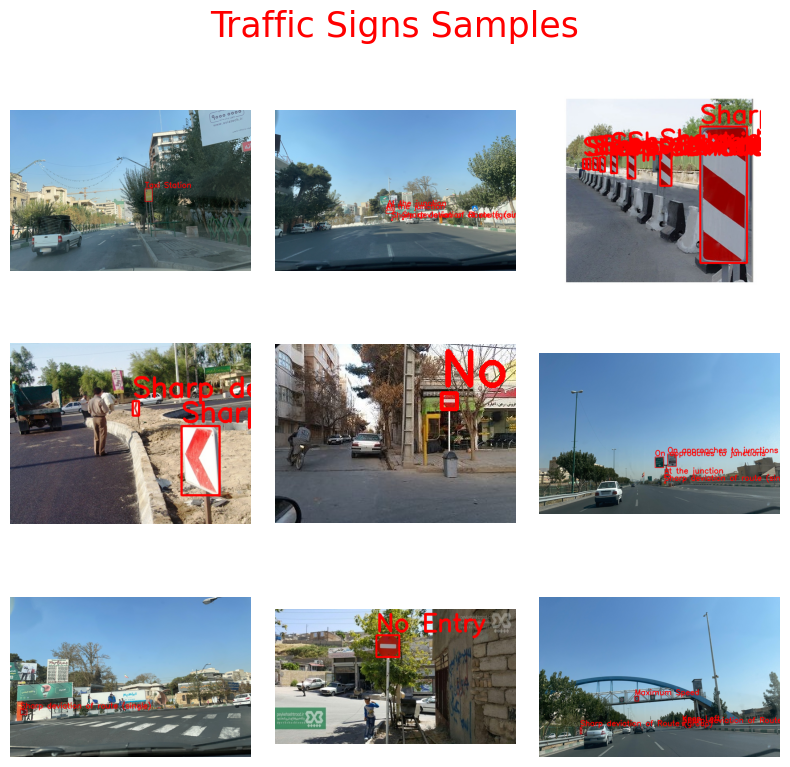

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import numpy as np


def display_sample_images(num_of_images=1, figsize=(8, 8), data_folder=r'dataset\train'):
    ncols = 3 if num_of_images > 3 else num_of_images
    nrows = int(np.ceil(num_of_images / 3))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.suptitle('Traffic Signs Samples', fontsize=25, color='r')

    axes = ax.flatten() if num_of_images > 1 else [ax]

    image_files = sorted([f for f in os.listdir(data_folder) if f.lower().endswith('.jpg')])

    for i in range(num_of_images):
        img_file = image_files[i]
        xml_file = img_file.replace('.jpg', '.xml')
        cur_img_path = os.path.join(data_folder, img_file)
        cur_label_path = os.path.join(data_folder, xml_file)

        if not os.path.exists(cur_label_path):
            print(f"Label file missing for {img_file}")
            continue

        obj = parse_xml_tree(cur_label_path)
        boxes = obj[3]

        image = cv2.imread(cur_img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for box in boxes:
            label = box['label']
            bbox = box['bbox']
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])

            cv2.rectangle(image, start_point, end_point, (255, 0, 0), 3)  # Red color

            # Label text
            cv2.putText(image, label, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 5)

        axes[i].imshow(image)
        axes[i].axis('off')

    for k in range(num_of_images, len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88, wspace=0.1, hspace=0.2)
    plt.savefig('traffic_samples.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
display_sample_images(9)

# **_Load Model_**

In [ ]:
import mlflow
from ultralytics import YOLO
import os
import json

# Set the experiment name
mlflow.set_tracking_uri("http://127.0.0.1:8000")  # Explicitly set URI
mlflow.set_experiment("YOLOv8 Experiment")

epochs = 50
imgsz = 640
batch_size = 32
model_name = 'yolov8m.pt'

# Start MLflow run
with mlflow.start_run(run_name=f"Model = {model_name}: imgsz = {imgsz}, batch_size = {batch_size}"):


    model = YOLO(model_name)
    # Log basic training parameters
    mlflow.log_param("model", model_name.replace('.pt',''))
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("imgsz", imgsz)
    mlflow.log_param('batch_size',batch_size)
    mlflow.log_param("learning_rate", model.overrides.get('lr0', None))
    mlflow.log_param("data", "data.yaml")

    results = model.train(data="data.yaml", epochs=epochs, imgsz=imgsz, batch=batch_size)
    # Train the YOLOv8 model

    # Load metrics from training folder
    metrics_path = "runs/train/exp/metrics.json"
    if os.path.exists(metrics_path):
        with open(metrics_path, "r") as f:
            metrics = json.load(f)
            mlflow.log_metric("mAP50", metrics.get("metrics/mAP_0.5", 0))
            mlflow.log_metric("precision", metrics.get("metrics/precision", 0))
            mlflow.log_metric("recall", metrics.get("metrics/recall", 0))

    # Log the best model weights as an artifact
    best_weights_path = "runs/train/exp/weights/best.pt"
    if os.path.exists(best_weights_path):
        mlflow.log_artifact(best_weights_path)



New https://pypi.org/project/ultralytics/8.3.129 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.110  Python-3.11.12 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, sav

train: Scanning C:\Users\hosam\OneDrive\Desktop\DEPI\Final_Project\Traffic_Signs\Yolo_Dataset\labels\train.cache... 674 images, 2 backgrounds, 0 corrupt: 100%|██████████| 676/676 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1264.0441.1 MB/s, size: 820.6 KB)


val: Scanning C:\Users\hosam\OneDrive\Desktop\DEPI\Final_Project\Traffic_Signs\Yolo_Dataset\labels\val.cache... 164 images, 3 backgrounds, 1 corrupt: 100%|██████████| 168/168 [00:00<?, ?it/s]

val: WARNING  C:\Users\hosam\OneDrive\Desktop\DEPI\Final_Project\Traffic_Signs\Yolo_Dataset\images\val\49000.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'tif', 'jpg', 'bmp', 'dng', 'mpo', 'pfm', 'png', 'webp', 'tiff', 'jpeg', 'heic'}
videos: {'wmv', 'mp4', 'avi', 'm4v', 'webm', 'mkv', 'mpg', 'mpeg', 'ts', 'asf', 'gif', 'mov'}


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000455, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)


2025/05/09 01:46:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/05/09 01:46:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(e0f082a807f44037b9a0e24b78db3220) to http://127.0.0.1:8000
MLflow: disable with 'yolo settings mlflow=False'


In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Your class names
CLASS_NAMES = [
    "Taxi Station", "At the junction", "Sharp deviation of Route (group)",
    "Sharp deviation of route (single)", "No Entry", "On approaches to junctions",
    "Maximum Speed", "Keep Left", "Pedestrian Route", "Keep Right",
    "No through road", "Give Way", "Stop", "No Stopping",
    "One-way Traffic", "No Waiting", "Area with Camera", "Transport with Crane"
]

def predict_and_draw_boxes(image_path, model_path='runs/detect/train/weights/best.pt', conf_threshold=0.25):
    # Load YOLO model
    model = YOLO(model_path)

    # Predict on image
    results = model(image_path)[0]

    # Read image with OpenCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Loop through results and draw boxes
    for box in results.boxes:
        cls_id = int(box.cls)
        conf = float(box.conf)
        if conf < conf_threshold:
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        label = CLASS_NAMES[cls_id] if cls_id < len(CLASS_NAMES) else f"Class {cls_id}"

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Put label
        cv2.putText(image, f"{label} {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Detected Objects")
    plt.show()



image 1/1 c:\Users\hosam\OneDrive\Desktop\DEPI\Final_Project\Traffic_Signs\Yolo_Dataset\images\test\96.jpg: 192x256 (no detections), 12.9ms
Speed: 1.3ms preprocess, 12.9ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 256)


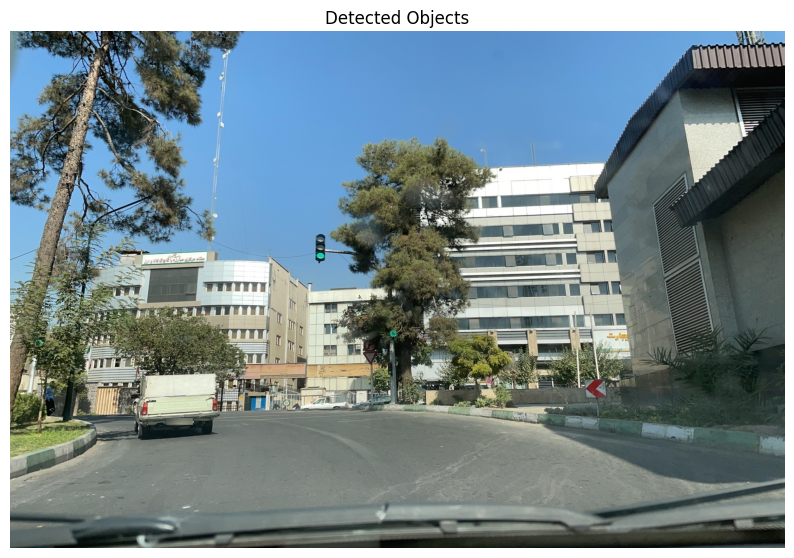

In [ ]:
predict_and_draw_boxes(r'Yolo_Dataset\images\test\96.jpg')